In [1]:
import os
import pandas as pd
import torch

from rdkit import Chem # safe import before ccdc imports
from torch_geometric.loader import DataLoader
from torch.utils.data import ConcatDataset

from conf_ensemble_dataset_in_memory import ConfEnsembleDataset
from litschnet import LitSchNet
from molsize_model import MolSizeModel
from rmsd_predictor_evaluator import RMSDPredictorEvaluator
from tqdm import tqdm

# Data preparation

In [2]:
# run once to preprocess datasets and generate chunks
dataset = ConfEnsembleDataset()
# dataset = ConfEnsembleDataset(dataset='platinum') # 16G

In [3]:
def get_train_smiles(split, 
                     iteration, 
                     data_dir='data/') :
    
    if split in ['random', 'scaffold'] :
        with open(os.path.join(data_dir, f'ligand_{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
            train_smiles = f.readlines()
            train_smiles = [smiles.strip() for smiles in train_smiles]
            
    elif split == 'ecfp' :
        with open(os.path.join(data_dir, f'ecfp_similarity_splits', f'train_smiles_{split}_similarity_split_{iteration}.txt'), 'r') as f :
            train_smiles = f.readlines()
            train_smiles = [smiles.strip() for smiles in train_smiles]
            
    elif split == 'protein':
        with open(os.path.join(data_dir, 'protein_similarity_splits', f'train_pdb_protein_similarity_split_{iteration}.txt'), 'r') as f :
            train_pdbs = f.readlines()
            train_pdbs = [pdb.strip() for pdb in train_pdbs]
        smiles_df = pd.read_csv('data/smiles_df.csv')
        train_smiles = smiles_df[smiles_df['id'].isin(train_pdbs)]['smiles'].values
        
    return train_smiles

In [4]:
def get_test_dataset(split, 
                    iteration, 
                    data_dir='data/') :
    
    train_smiles = get_train_smiles(split, iteration, data_dir)
    
    test_dataset_path = os.path.join(data_dir, f'test_dataset_{split}_{iteration}.p')
    if not os.path.exists(test_dataset_path) :
    
        pdbbind_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('pdbbind')]
        pdbbind_n_chunks = len(pdbbind_chunks)
    
        test_datasets = []
    
        if split in ['random', 'scaffold'] :
            
            with open(os.path.join(data_dir, f'ligand_{split}_splits', f'test_smiles_{split}_split_{iteration}.txt'), 'r') as f :
                test_smiles = f.readlines()
                test_smiles = [smiles.strip() for smiles in test_smiles]

            for chunk_number in tqdm(range(pdbbind_n_chunks)) :
                dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                              smiles_list=test_smiles)
                test_datasets.append(dataset)

        elif split == 'ecfp' :

            with open(os.path.join(data_dir, f'ecfp_similarity_splits', f'test_smiles_{split}_similarity_split_{iteration}.txt'), 'r') as f :
                test_smiles = f.readlines()
                test_smiles = [smiles.strip() for smiles in test_smiles]

            for chunk_number in tqdm(range(pdbbind_n_chunks)) :

                dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                              smiles_list=test_smiles)
                test_datasets.append(dataset)
                
        elif split == 'protein' : #protein split

            with open(os.path.join(data_dir, 'protein_similarity_splits', f'test_pdb_protein_similarity_split_{iteration}.txt'), 'r') as f :
                test_pdbs = f.readlines()
                test_pdbs = [pdb.strip() for pdb in test_pdbs]
            
            for chunk_number in tqdm(range(pdbbind_n_chunks)) :
                dataset = ConfEnsembleDataset(loaded_chunk=chunk_number,
                                              pdb_ids_list=test_pdbs)
                test_datasets.append(dataset)

        test_dataset = ConcatDataset(test_datasets)
        torch.save(test_dataset, test_dataset_path)
    
    else : #Load dataset
        test_dataset = torch.load(test_dataset_path)
    
    return test_dataset, train_smiles

In [5]:
def get_model(experiment_name) :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    if 'molsize' in experiment_name :
        model = MolSizeModel.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    return model

In [6]:
def evaluate_model(experiment_name,
                   test_dataset,
                   #platinum_dataset,
                   training_smiles,
                   tasks = ['all', 'easy', 'hard']) :
    
    model = get_model(experiment_name)
    
    evaluation_name = experiment_name + '_pdbbind'
    evaluator = RMSDPredictorEvaluator(model=model, 
                                       evaluation_name=evaluation_name,
                                       training_smiles=train_smiles)
#     evaluator.evaluate(test_dataset)
    evaluator.evaluate(test_dataset, overwrite=True)
    for task in tasks :
        evaluator.evaluation_report(task=task)

#     evaluation_name = experiment_name + '_platinum'
#     evaluator = RMSDPredictorEvaluator(model=model, 
#                                        evaluation_name=evaluation_name,
#                                        training_smiles=train_smiles)
#     evaluator.evaluate(platinum_dataset, overwrite=True)
#     for task in tasks :
#         evaluator.evaluation_report(task=task)

In [7]:
data_dir = 'data/'
# platinum_chunks = [filename for filename in os.listdir(os.path.join(data_dir, 'processed')) if filename.startswith('platinum')]
# platinum_n_chunks = len(platinum_chunks)

In [8]:
# platinum_datasets = []
# for chunk_number in tqdm(range(platinum_n_chunks)) :
#     dataset = ConfEnsembleDataset(dataset='platinum', loaded_chunk=chunk_number)
#     platinum_datasets.append(dataset)
# platinum_dataset = ConcatDataset(platinum_datasets)

In [9]:
splits = ['random', 'scaffold', 'protein']
iterations = list(range(5))

In [10]:
%%time

# for split in splits :
for split in ['ecfp'] :

#     for iteration in range(2, 5) :
    for iteration in iterations :

        test_dataset, train_smiles = get_test_dataset(split, iteration)
        
        experiment_name = f'{split}_split_{iteration}'
        # evaluate_model(experiment_name, test_dataset, platinum_dataset, train_smiles)
        evaluate_model(experiment_name, test_dataset, train_smiles)
        
#         experiment_name = f'{split}_split_{iteration}_molsize'
#         evaluate_model(experiment_name, test_dataset, train_smiles)

100%|█████████████████████████████████████████████| 3/3 [01:18<00:00, 26.02s/it]


Computing training set fingerprints
Grouping data by smiles


  0%|                                                  | 0/1374 [00:00<?, ?it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [01:22<00:00, 27.50s/it]


Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1376 [00:00<01:31, 14.97it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [01:20<00:00, 26.91s/it]


Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1368 [00:00<01:21, 16.85it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [01:18<00:00, 26.08s/it]


Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1079 [00:00<01:14, 14.40it/s]

Starting evaluation


100%|█████████████████████████████████████████████| 3/3 [01:27<00:00, 29.05s/it]


Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1372 [00:00<01:33, 14.61it/s]

Starting evaluation


100%|███████████████████████████████████████| 1372/1372 [01:18<00:00, 17.58it/s]


CPU times: user 2h 1min 25s, sys: 1min 55s, total: 2h 3min 21s
Wall time: 26min 55s


In [9]:
%%time
for split in splits :
    for iteration in iterations :
        test_dataset, train_smiles = get_test_dataset(split, iteration)
        experiment_name = f'{split}_split_{iteration}_molsize'
        evaluate_model(experiment_name, test_dataset, train_smiles)

Computing training set fingerprints
Grouping data by smiles


  0%|                                                  | 0/1258 [00:00<?, ?it/s]

Starting evaluation


100%|███████████████████████████████████████| 1258/1258 [00:42<00:00, 29.70it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1258 [00:00<00:47, 26.15it/s]

Starting evaluation


100%|███████████████████████████████████████| 1258/1258 [00:43<00:00, 28.98it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1258 [00:00<00:43, 28.92it/s]

Starting evaluation


100%|███████████████████████████████████████| 1258/1258 [00:43<00:00, 28.65it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1259 [00:00<00:44, 28.17it/s]

Starting evaluation


100%|███████████████████████████████████████| 1259/1259 [00:41<00:00, 30.07it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1257 [00:00<00:48, 25.91it/s]

Starting evaluation


100%|███████████████████████████████████████| 1257/1257 [00:43<00:00, 28.63it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1283 [00:00<01:02, 20.44it/s]

Starting evaluation


100%|███████████████████████████████████████| 1283/1283 [00:51<00:00, 25.15it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1304 [00:00<00:54, 23.71it/s]

Starting evaluation


100%|███████████████████████████████████████| 1304/1304 [00:51<00:00, 25.50it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1158 [00:00<00:44, 26.18it/s]

Starting evaluation


100%|███████████████████████████████████████| 1158/1158 [00:45<00:00, 25.71it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|▏                                         | 4/1240 [00:00<00:42, 28.75it/s]

Starting evaluation


100%|███████████████████████████████████████| 1240/1240 [00:48<00:00, 25.71it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1252 [00:00<01:15, 16.57it/s]

Starting evaluation


100%|███████████████████████████████████████| 1252/1252 [00:49<00:00, 25.10it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1412 [00:00<01:12, 19.45it/s]

Starting evaluation


100%|███████████████████████████████████████| 1412/1412 [00:59<00:00, 23.55it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 3/1429 [00:00<01:11, 19.96it/s]

Starting evaluation


100%|███████████████████████████████████████| 1429/1429 [01:02<00:00, 22.93it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1373 [00:00<01:15, 18.23it/s]

Starting evaluation


100%|███████████████████████████████████████| 1373/1373 [00:58<00:00, 23.50it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1414 [00:00<01:17, 18.32it/s]

Starting evaluation


100%|███████████████████████████████████████| 1414/1414 [01:00<00:00, 23.32it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

Computing training set fingerprints
Grouping data by smiles


  0%|                                          | 2/1345 [00:00<01:16, 17.63it/s]

Starting evaluation


100%|███████████████████████████████████████| 1345/1345 [01:05<00:00, 20.54it/s]
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/numpy/core/_methods.p

CPU times: user 4h 26min 58s, sys: 4min, total: 4h 30min 59s
Wall time: 47min 4s


In [10]:
len(test_dataset)

96219

In [11]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [12]:
def plot_ecdf_bioactive_like(active_ratio_threshold=0.1) :
    rankers = ['model', 'energy', 'ccdc', 'random']
    task = 'all'

    mol_results_path = 'results/random_split_0_pdbbind/mol_results.p'
    with open(mol_results_path, 'rb') as f:
        mol_results = pickle.load(f)

    included_smiles = []
    for smiles, mol_result in mol_results.items() :
        n_generated = mol_result['n_generated']
        has_generated = n_generated > 1
        is_easy = n_generated < 100
        is_hard = n_generated == 100
        task_filter = (task == 'all') or (task == 'hard' and is_hard) or (task == 'easy' and is_easy)
        include_smiles = task_filter and has_generated
        if include_smiles :
            included_smiles.append(smiles)

    rankers_ranks = defaultdict(list)
    rank_name = 'normalized_first_bioactive_like_rank'

    for ranker in rankers :
        for smiles in included_smiles :
            mol_result = mol_results[smiles]
            if rank_name in mol_result :
                rank = mol_result[rank_name][ranker]
                n_actives = mol_result['n_actives']
                n_generated = mol_result['n_generated']
                active_ratio = n_actives / n_generated
                if active_ratio < active_ratio_threshold :
                    rankers_ranks[ranker].append(rank)

    clean_ranker_names = {'model' : 'BioSchNet',
                                       'model_random' : 'BioSchNet (random split)',
                                       'model_scaffold' : 'BioSchNet (scaffold split)',
                                       'model_protein' : 'BioSchNet (protein split)',
                                       'energy' : 'UFF energy',
                                       'random' : 'Random',
                                       'ccdc' : 'CCDC'}

    xlabel = 'Normalized rank of bioactive-like'
    suffix = 'generated'
    master_df = pd.DataFrame()
    for ranker in rankers_ranks :
        ranks = rankers_ranks[ranker]
        df = pd.DataFrame({xlabel : ranks})
        df['Ranker'] = ranker
        master_df = pd.concat([master_df, df])

    master_df['Ranker'] = master_df['Ranker'].replace(clean_ranker_names)

    with sns.plotting_context('talk', font_scale=0.7) :
        sns.ecdfplot(data=master_df, x=xlabel, hue='Ranker')
        plt.tight_layout()

    plt.title(f'Ratio of actives < {active_ratio_threshold}')
    plt.show()

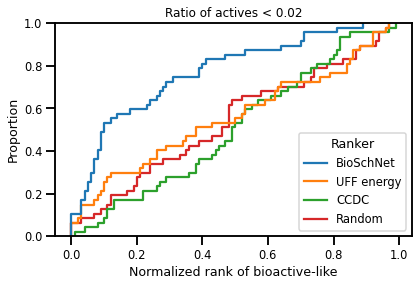

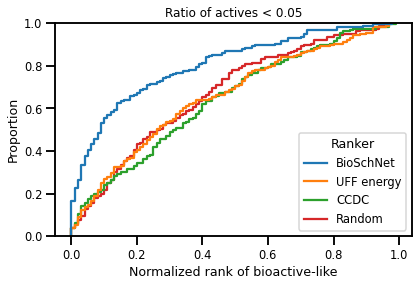

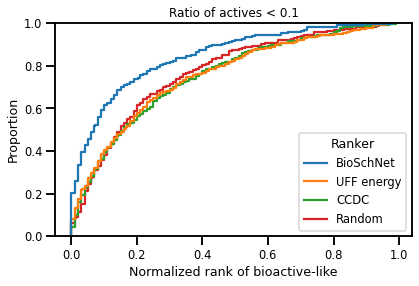

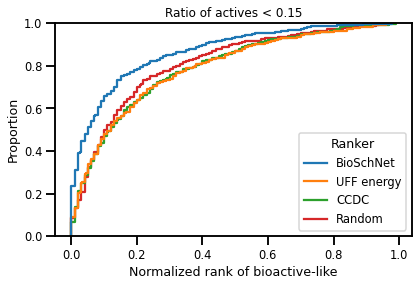

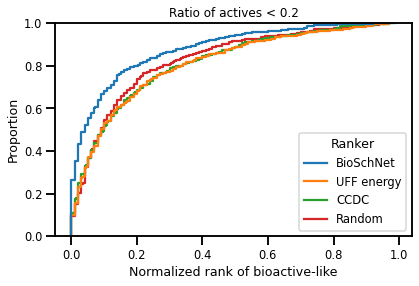

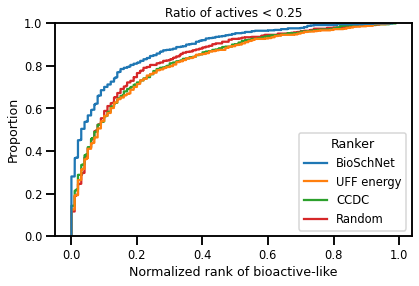

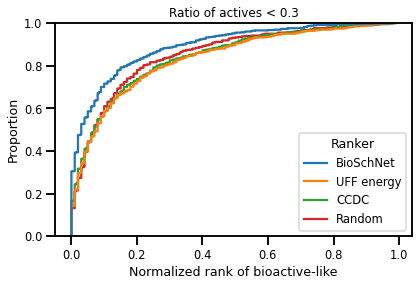

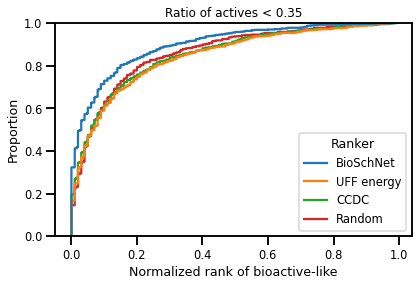

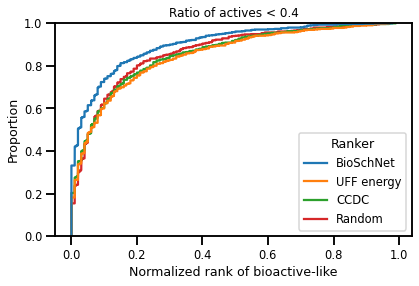

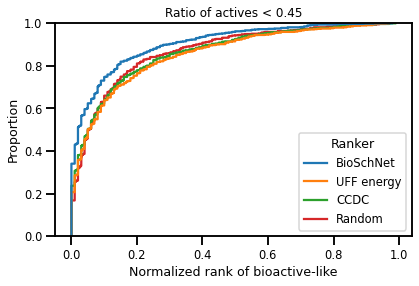

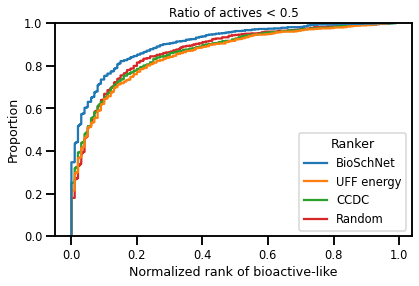

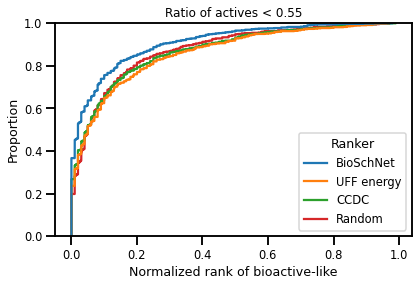

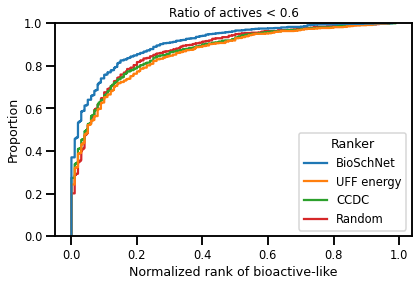

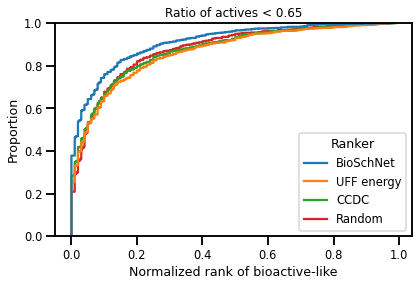

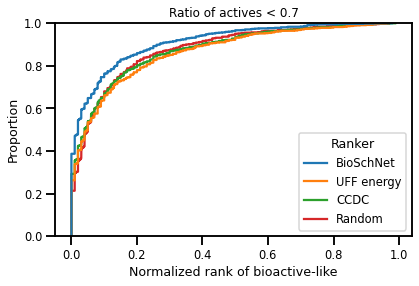

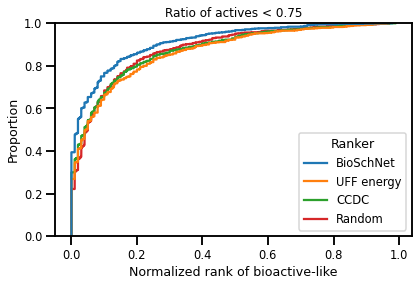

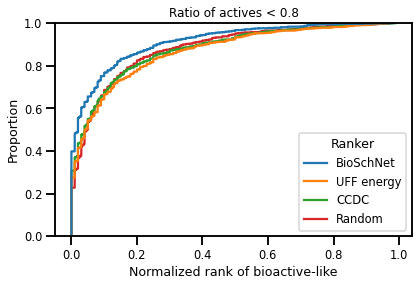

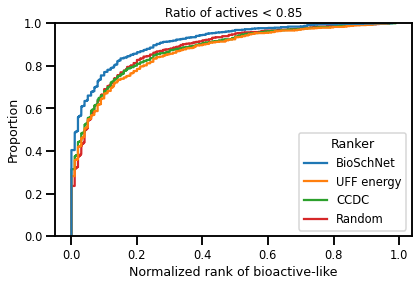

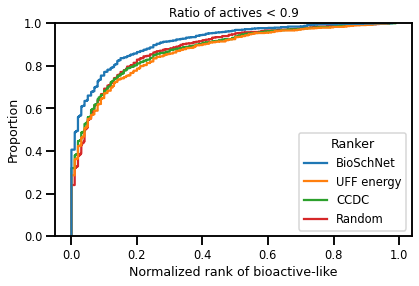

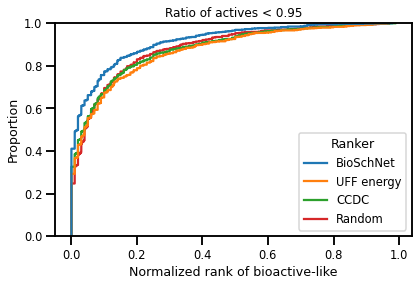

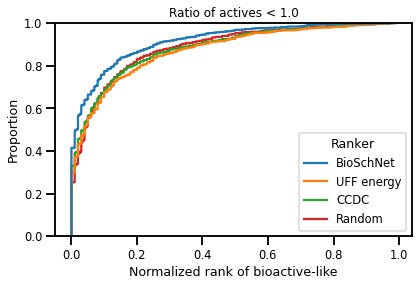

In [13]:
plot_ecdf_bioactive_like(0.02)
for i in range(5, 105, 5) :
    plot_ecdf_bioactive_like(i / 100)